In [22]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd

### Connect to PostgreSQL

In [23]:
conn = psycopg2.connect(
    database="shefalisharma",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Create a cursor object
cur = conn.cursor()

# Execute SQL query
#cur.execute("SELECT * FROM apple_music_dataset LIMIT 4")

# Fetch data
#data = cur.fetchall()




#### Execute Q1: Analysing Genre's and their track released over the years

In [20]:
cur = conn.cursor()

cur.execute("""
WITH genre_table AS (
    SELECT "primaryGenreName", DATE_TRUNC('year', "releaseDate")::date AS release_year, COUNT("trackId") AS track_count
    FROM apple_music_dataset
    GROUP BY "primaryGenreName", DATE_TRUNC('year', "releaseDate")
),
years AS (
    SELECT GENERATE_SERIES(MIN("releaseDate"), MAX("releaseDate"), '1 year'::interval)::date AS years
    FROM apple_music_dataset
),
all_genres AS (
    SELECT DISTINCT "primaryGenreName" AS genre FROM apple_music_dataset
),
cross_join_genre_years AS (
    SELECT years.years, all_genres.genre
    FROM years, all_genres
)
SELECT genre, years, COALESCE(genre_table.track_count, 0) AS count, AVG(COALESCE(genre_table.track_count, 0)) OVER(PARTITION BY genre)
FROM cross_join_genre_years cjgy
LEFT JOIN genre_table ON genre_table."primaryGenreName" = cjgy.genre AND genre_table.release_year = cjgy.years
""")
# Get column names from cursor description
column_names_1 = [desc[0] for desc in cur.description]

# Fetch the data
q1_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q1_data_df = pd.DataFrame(q1_data, columns=column_names_1)
cur.close()


In [30]:
q1_data_df.head(5)
# print head when the df is sorted by count in Descending
q1_data_df.describe()

,count
count,7125.000000
mean,1.226807
std,7.179552
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,145.000000


## Close cursor and connection

In [41]:
cur.close()
conn.close()

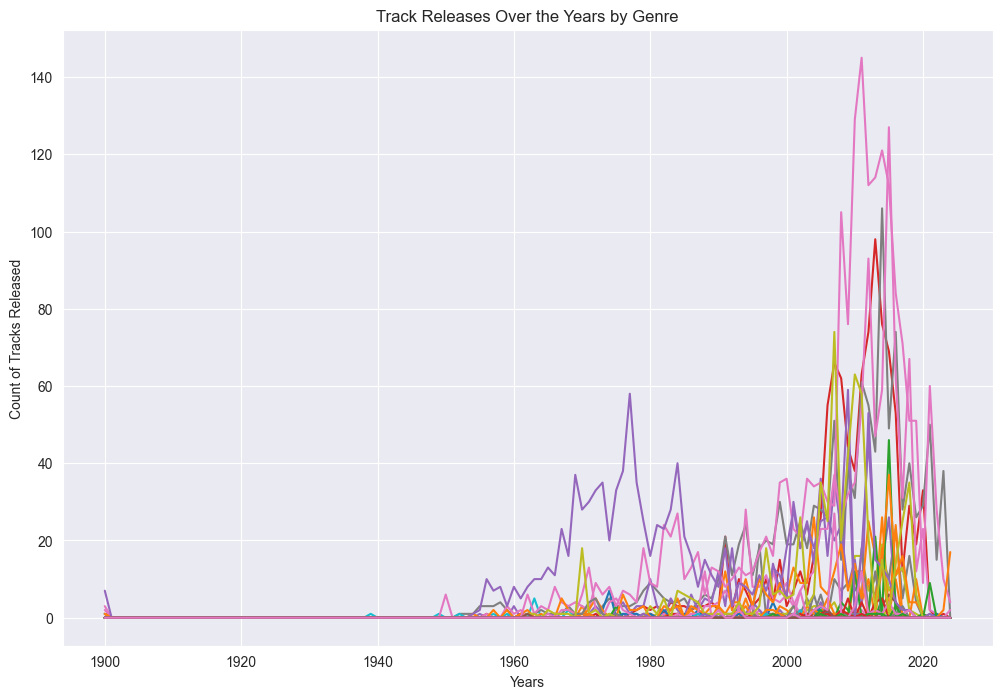

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# Grouped the DataFrame by genre
grouped_df = q1_data_df.groupby('genre')

# Plotting a line for each genre
plt.figure(figsize=(12, 8))
for genre, group in grouped_df:
    years = np.array(group['years'])  # Convert to numpy array
    counts = np.array(group['count'])  # Convert to numpy array
    plt.plot(years, counts, label=genre)

# Labels and Title
plt.xlabel('Years')
plt.ylabel('Count of Tracks Released')
plt.title('Track Releases Over the Years by Genre')
#plt.legend()

plt.grid(True)
plt.show()


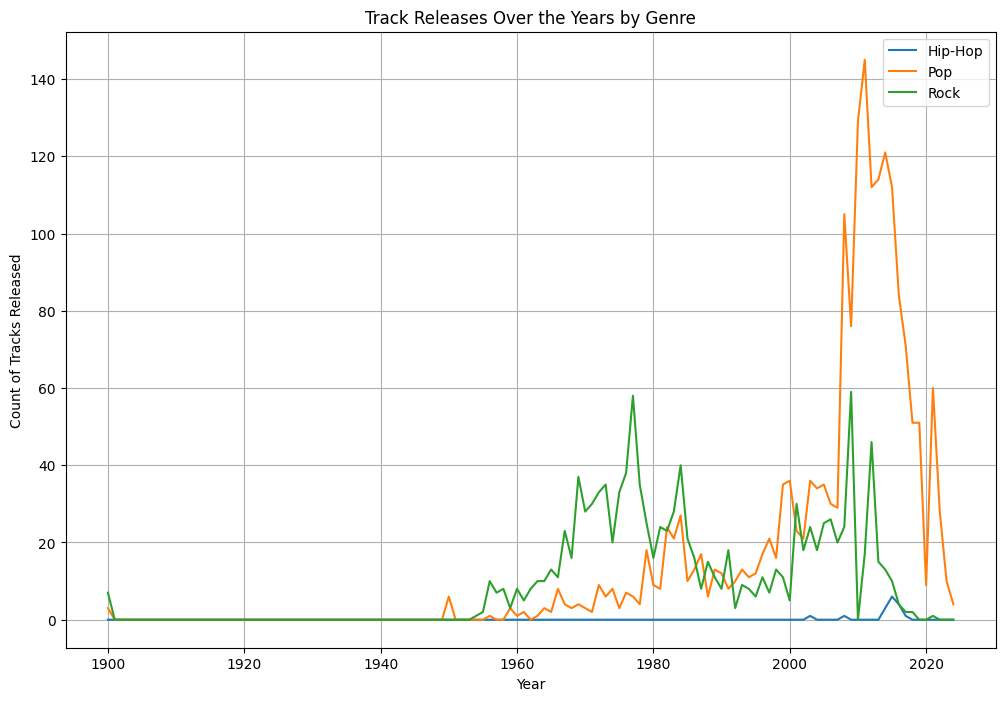

In [38]:

# Define a function to plot the line chart based on selected genres
def plot_line_chart(selected_genres):
    selected_data = q1_data_df[q1_data_df['genre'].isin(selected_genres)]
    plt.figure(figsize=(12, 8))
    for genre, group in selected_data.groupby('genre'):
        years = np.array(group['years'])  # Convert years to numpy array
        counts = np.array(group['count'])  # Convert counts to numpy array
        plt.plot(years, counts, label=genre)
    plt.xlabel('Year')
    plt.ylabel('Count of Tracks Released')
    plt.title('Track Releases Over the Years by Genre')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sample list of genres
all_genres = q1_data_df['genre'].unique().tolist()

# Sample user selection
selected_genres = ['Pop', 'Rock', 'Hip-Hop']

# Plot the line chart
plot_line_chart(selected_genres)


### Execute Q2: Distribution of track prices within each genre (explicit tracks only)

In [40]:
cur.execute("""
SELECT "primaryGenreName", SUM("trackPrice") AS sum_track_price, COUNT("trackId") AS count_tracks_released, 
ROUND(SUM("trackPrice")/COUNT("trackId")::decimal, 2) AS price_per_track, 
RANK() OVER(ORDER BY SUM("trackPrice")/COUNT("trackId") DESC) AS rank_avg_price
FROM apple_music_dataset
WHERE "trackExplicitness" = 'explicit'
GROUP BY "primaryGenreName"
ORDER BY sum_track_price DESC
""")



# Get column names from cursor description
column_names_2 = [desc[0] for desc in cur.description]

# Fetch Q2 data
q2_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q2_data_df = pd.DataFrame(q2_data, columns=column_names_2)
display(q2_data_df.head(5))


,primaryGenreName,sum_track_price,count_tracks_released,price_per_track,rank_avg_price
0,Hip-Hop/Rap,879.08,698,1.26,11
1,Pop,176.72,144,1.23,13
2,Alternative,117.39,91,1.29,1
3,Hard Rock,107.36,85,1.26,10
4,R&B/Soul,96.21,79,1.22,14


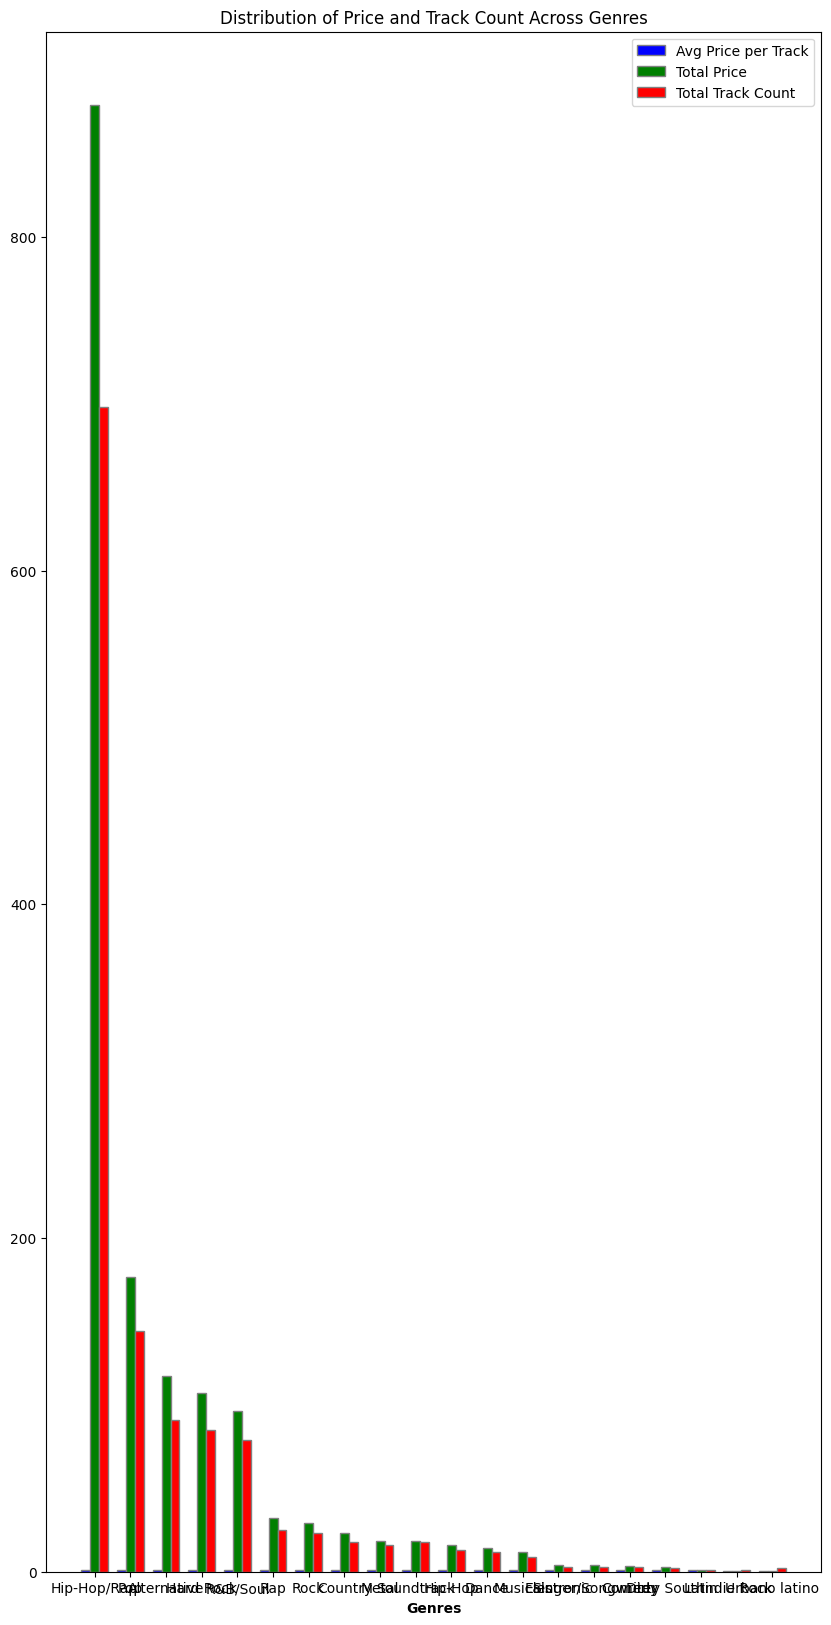

In [44]:


# Extract data from the DataFrame
genres = q2_data_df['primaryGenreName']
avg_price = q2_data_df['price_per_track']
total_price = q2_data_df['sum_track_price']
total_count = q2_data_df['count_tracks_released']

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = np.arange(len(genres))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar plot
plt.figure(figsize=(10, 20))
plt.bar(r1, avg_price, color='b', width=bar_width, edgecolor='grey', label='Avg Price per Track')
plt.bar(r2, total_price, color='g', width=bar_width, edgecolor='grey', label='Total Price')
plt.bar(r3, total_count, color='r', width=bar_width, edgecolor='grey', label='Total Track Count')

# Add xticks on the middle of the group bars
plt.xlabel('Genres', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(genres))], genres)

# Add a legend
plt.legend()

# Show the plot
plt.title('Distribution of Price and Track Count Across Genres')
plt.show()


/var/folders/9f/45cygnj93kn1977lgwr13g140000gn/T/ipykernel_52818/2470941235.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(genres, rotation=90, ha='right')


TypeError: can only concatenate tuple (not "list") to tuple

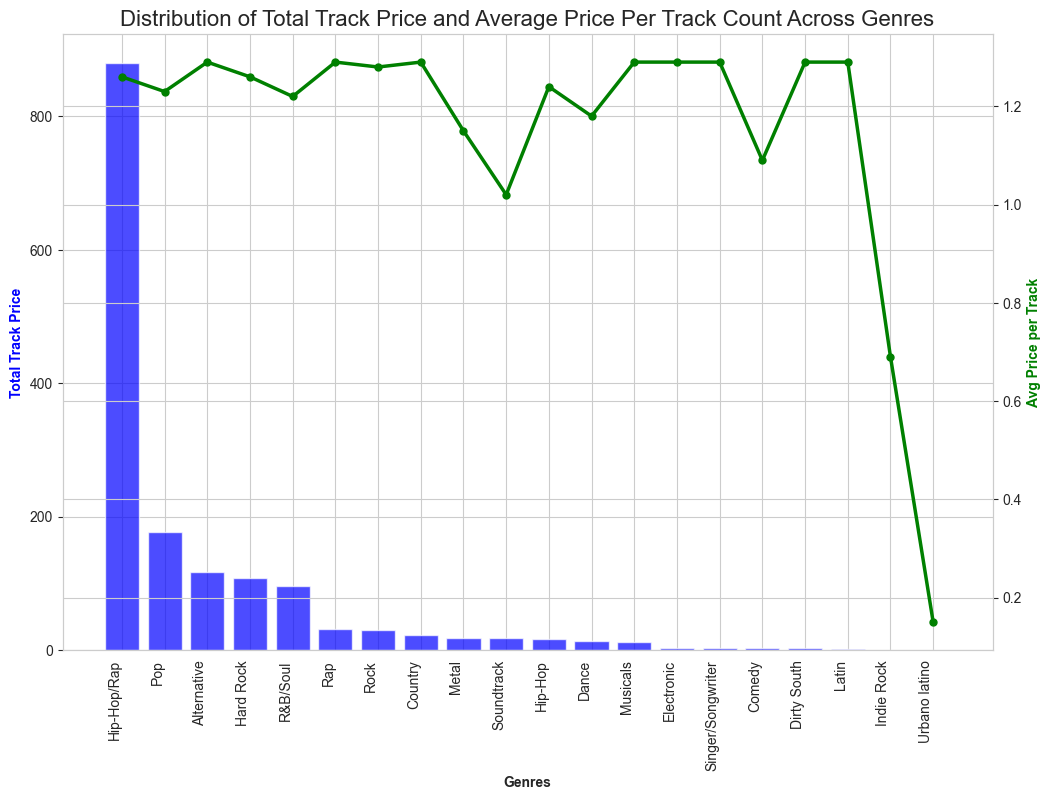

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style of seaborn
sns.set_style("whitegrid")

# Extract data as numpy arrays
genres = q2_data_df['primaryGenreName'].values
sum_track_price = q2_data_df['sum_track_price'].values
price_per_track = q2_data_df['price_per_track'].values

# Plotting with Matplotlib directly
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the bar plot for total price
bars = ax1.bar(genres, sum_track_price, color='b', alpha=0.7, label='Total Price')

# Set the labels and title for primary y-axis
ax1.set_xlabel('Genres', fontweight='bold')
ax1.set_ylabel('Total Track Price', color='b', fontweight='bold')
ax1.set_title('Distribution of Total Track Price and Average Price Per Track Count Across Genres', fontsize=16)

# Create secondary y-axis for average price per track
ax2 = ax1.twinx()
line = ax2.plot(genres, price_per_track, color='g', marker='o', markersize=5, linewidth=2.5, label='Avg Price per Track')

# Set the labels for secondary y-axis
ax2.set_ylabel('Avg Price per Track', color='g', fontweight='bold')

# Rotate x-axis labels for better readability
ax1.set_xticklabels(genres, rotation=90, ha='right')

# Combine legend for both primary and secondary plots
plots = bars + line
labels = [plot.get_label() for plot in plots]
ax1.legend(plots, labels, loc='upper left')

# Show the plot
plt.show()


### Q3: How does the popularity of tracks, measured by the number of tracks released, vary across different release years within each genre?

In [69]:
cur.execute("""

WITH ranked_genre AS(
SELECT "primaryGenreName", EXTRACT('year' FROM "releaseDate")::integer AS release_year, COUNT("trackId") AS no_tracks_released, RANK() OVER(PARTITION BY EXTRACT('year' FROM "releaseDate") ORDER BY COUNT("trackId") DESC)
FROM apple_music_dataset
GROUP BY "primaryGenreName", EXTRACT('year' FROM "releaseDate")
)

SELECT * FROM ranked_genre WHERE rank = 1 ORDER BY release_year DESC;
""")
# Get column names from cursor description
column_names_3 = [desc[0] for desc in cur.description]

# Fetch the data
q3_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q3_data_df = pd.DataFrame(q3_data, columns=column_names_3)

cur.close()

In [72]:
display(q3_data_df)

,primaryGenreName,release_year,no_tracks_released,rank
0,R&B/Soul,2024,17,1
1,Country,2023,38,1
2,Pop,2022,28,1
3,Pop,2021,60,1
4,Alternative,2020,33,1
...,...,...,...,...
78,Jazz,1952,1,1
79,Pop,1950,6,1
80,Christmas: Classic,1949,1,1
81,Jazz,1939,1,1


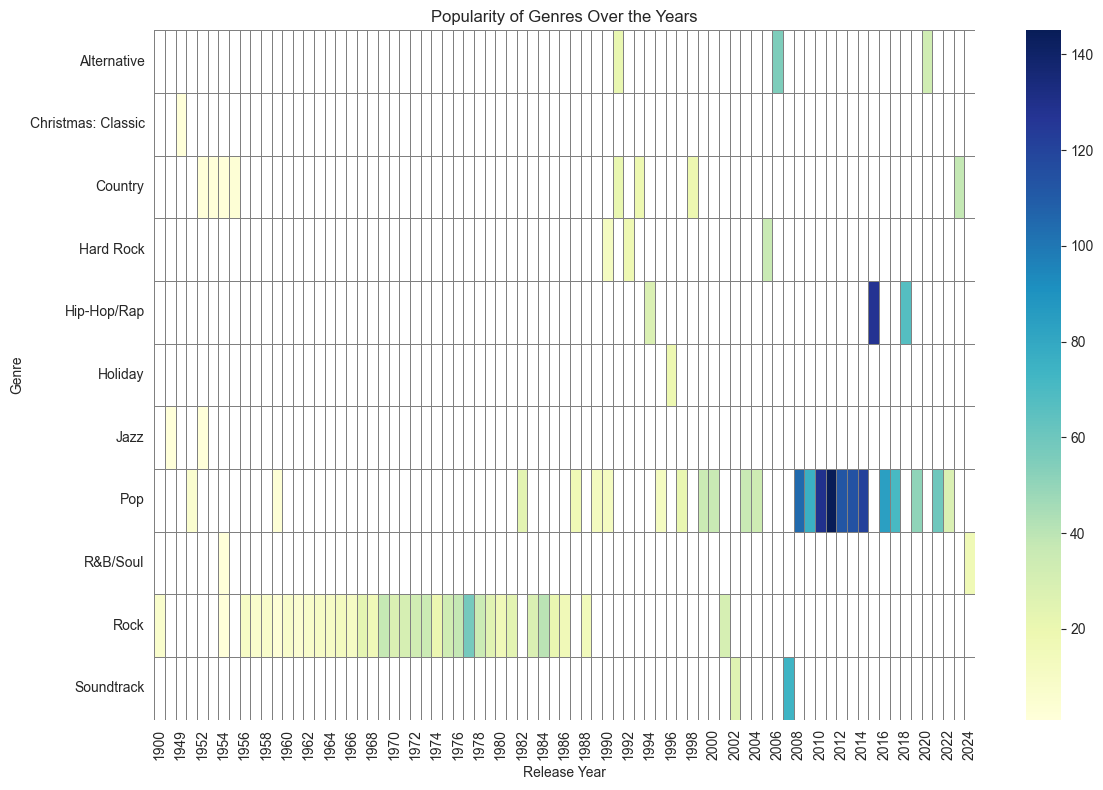

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to have years as columns and genres as rows
heatmap_data = q3_data_df.pivot(index='primaryGenreName', columns='release_year', values='no_tracks_released')

# Create the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='grey')
plt.title('Popularity of Genres Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Q4: What is the correlation between the track price and the track duration within each genre?

In [78]:
cur = conn.cursor()

cur.execute("""

SELECT "primaryGenreName", COALESCE(CORR("trackPrice", "trackTimeMillis"), 0) AS correlation 
FROM apple_music_dataset
GROUP BY "primaryGenreName"
ORDER BY correlation DESC;
""")
# Get column names from cursor description
column_names_4 = [desc[0] for desc in cur.description]

# Fetch the data
q4_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q4_data_df = pd.DataFrame(q4_data, columns=column_names_4)

cur.close()


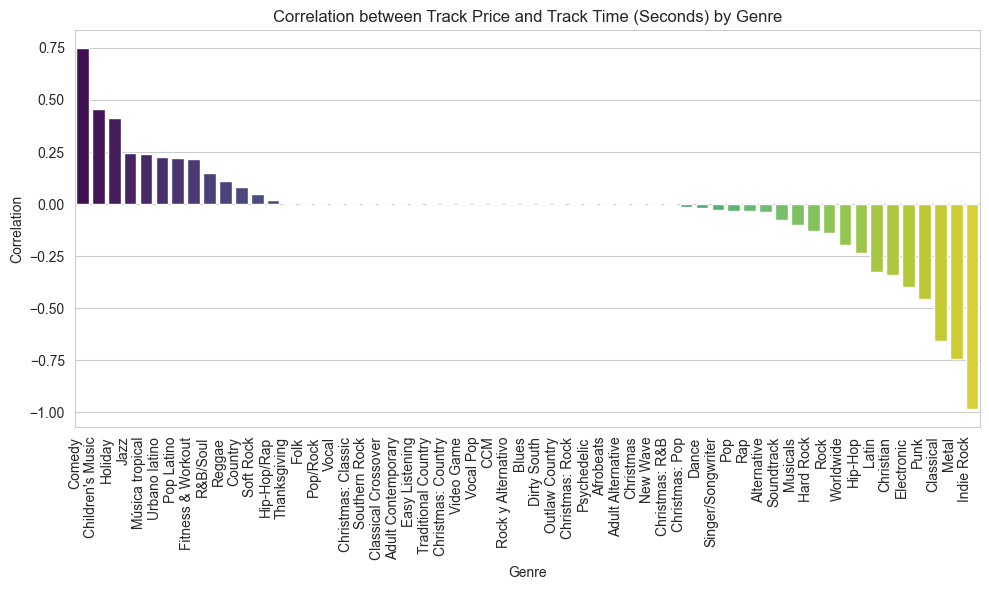

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation values using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=q4_data_df, x='primaryGenreName', y='correlation', hue='primaryGenreName', palette='viridis', legend=False)
plt.title('Correlation between Track Price and Track Time (Seconds) by Genre')
plt.xlabel('Genre')
plt.ylabel('Correlation')
plt.xticks(rotation=90, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()


### Q5: Can we identify any temporal patterns in the release dates of tracks within collections?

In [44]:
cur = conn.cursor()

cur.execute("""

WITH collection_table AS(
SELECT "collectionId","collectionName", MAX("releaseDate")::date AS last_release, MIN("releaseDate")::date AS first_release, MAX("releaseDate") - MIN("releaseDate") AS collection_release_duration
FROM apple_music_dataset
GROUP BY "collectionName", "collectionId"
ORDER BY collection_release_duration DESC),

collection_table2 AS
( 
SELECT DISTINCT "collectionId", "collectionName", "primaryGenreName"
FROM apple_music_dataset
)
SELECT "primaryGenreName", collection_table."collectionName", first_release, last_release, collection_release_duration
FROM collection_table JOIN collection_table2
ON collection_table."collectionId" = collection_table2."collectionId"
ORDER BY "collectionName" DESC;
""")
# Get column names from cursor description
column_names_5 = [desc[0] for desc in cur.description]

# Fetch the data
q5_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q5_data_df = pd.DataFrame(q5_data, columns=column_names_5)

cur.close()


In [45]:
display(q5_data_df)

,primaryGenreName,collectionName,first_release,last_release,collection_release_duration
0,Alternative,xx (Bonus Track Version),2009-08-14,2009-08-14,0 days 00:00:00
1,Pop,x (Deluxe Edition),2014-04-07,2014-06-20,74 days 00:00:00
2,Pop,x,2014-04-07,2014-06-20,74 days 00:00:00
3,Pop,us,2016-03-25,2016-03-25,0 days 00:00:00
4,Pop,us,2016-03-25,2016-03-25,0 days 00:00:00
...,...,...,...,...,...
2838,Pop,#3 (Deluxe Version),2012-08-19,2012-08-19,0 days 00:00:00
2839,Pop,#3 (Deluxe Version),2012-08-20,2012-08-20,0 days 00:00:00
2840,R&B/Soul,#1's: Destiny's Child,2001-02-13,2001-02-13,0 days 00:00:00
2841,Comedy,"""Weird Al"" Yankovic's Greatest Hits",1983-01-01,1983-01-01,0 days 00:00:00


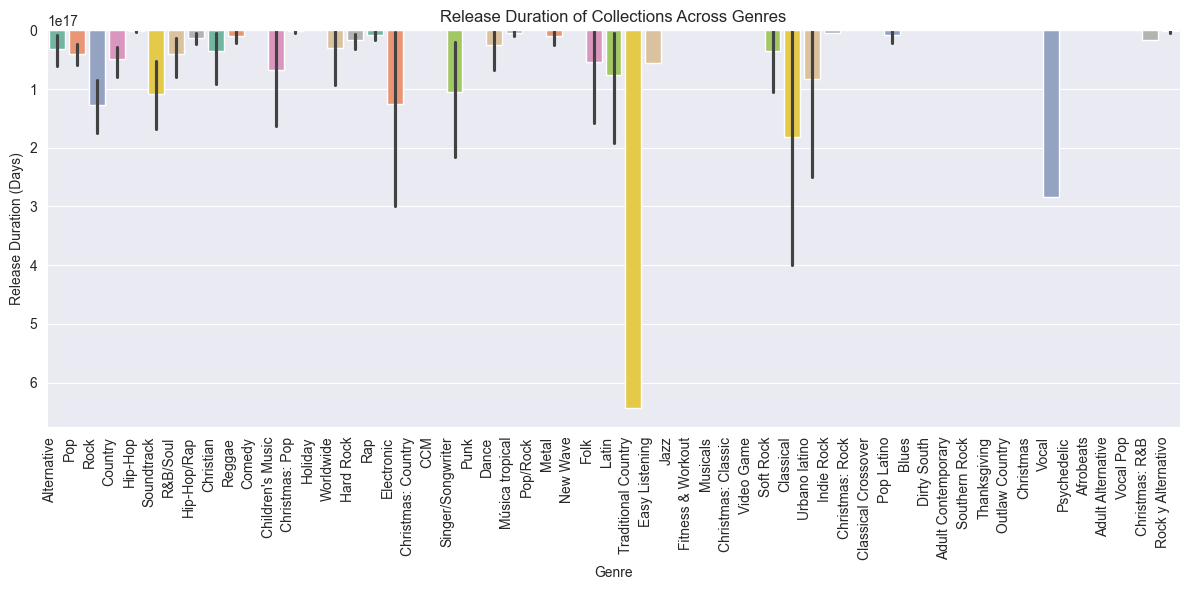

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the release duration of collections across genres using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=q5_data_df, x='primaryGenreName', y='collection_release_duration', hue='primaryGenreName', palette='Set2', legend=False)
plt.title('Release Duration of Collections Across Genres')
plt.xlabel('Genre')
plt.ylabel('Release Duration (Days)')
plt.xticks(rotation=90, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()


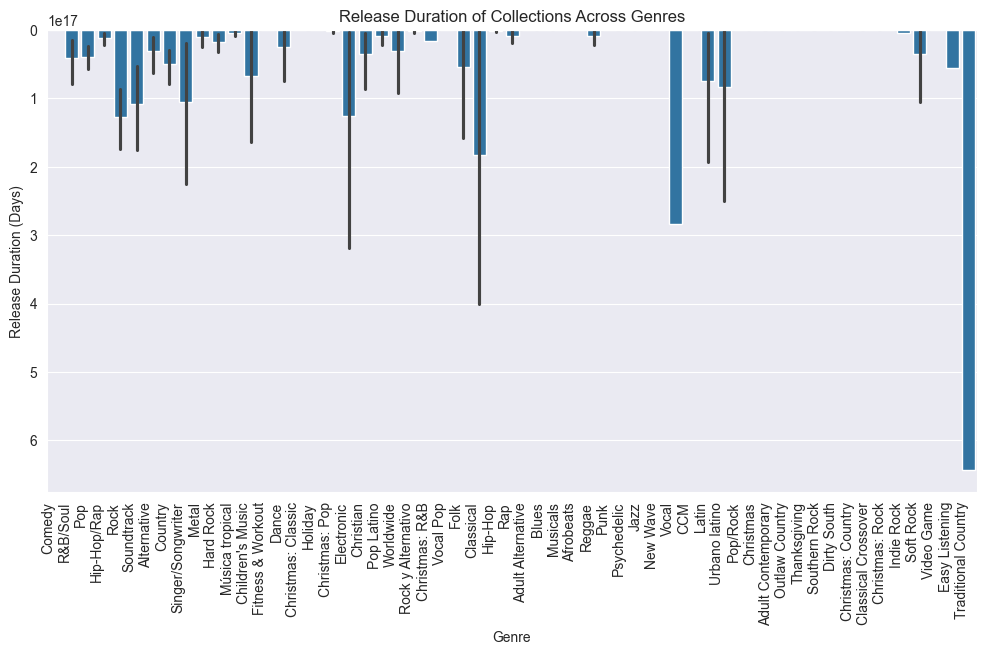

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by collectionName alphabetically

genre_ordered = q5_data_df_sorted['primaryGenreName'].unique()

# Plotting the release duration of collections across genres using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=q5_data_df, x='primaryGenreName', y='collection_release_duration', legend=False, order=genre_ordered)
plt.title('Release Duration of Collections Across Genres')
plt.xlabel('Genre')
plt.ylabel('Release Duration (Days)')
plt.xticks(rotation=90, ha='right')  # Rotate x-labels for better readability
plt.show()


### Q6: How does the distribution of track prices vary between single tracks and tracks within collections?

In [87]:
cur = conn.cursor()

cur.execute("""

WITH category_tracks AS 
(
SELECT "collectionId", COUNT("trackId"), CASE WHEN COUNT("trackId") = 1 THEN 'single' ELSE 'collection' END AS category_of_track 
FROM apple_music_dataset 
GROUP BY "collectionId"
)

SELECT category_of_track, SUM("trackPrice") AS sum_price, ROUND(AVG("trackPrice"),3) AS avg_track_price, COUNT("trackId")/COUNT(DISTINCT category_tracks."collectionId") AS avg_nos_of_tracks_collection, COUNT(DISTINCT category_tracks."collectionId") AS "No. of Collections"
FROM apple_music_dataset JOIN category_tracks
ON apple_music_dataset."collectionId" = category_tracks."collectionId"
GROUP BY category_of_track;

""")
# Get column names from cursor description
column_names_6 = [desc[0] for desc in cur.description]

# Fetch the data
q6_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q6_data_df = pd.DataFrame(q6_data, columns=column_names_6)

cur.close()


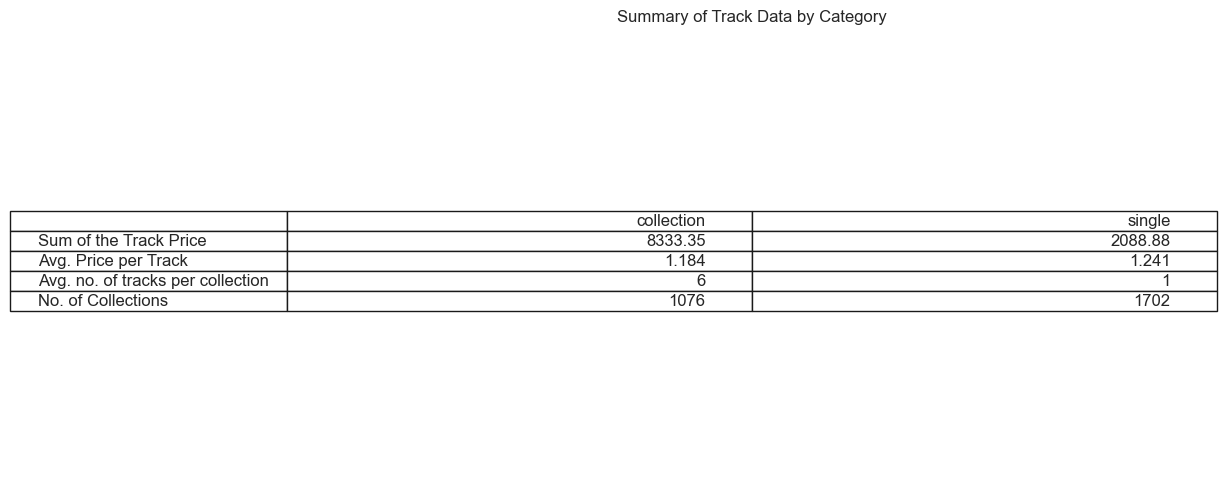

In [92]:
import matplotlib.pyplot as plt

# Update column names
q6_data_df.columns = ["", "Sum of the Track Price", "Avg. Price per Track", "Avg. no. of tracks per collection", "No. of Collections"]

# Transpose the DataFrame
q6_data_df_transposed = q6_data_df.T

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.axis('off')

# Create the table plot
table = ax.table(cellText=q6_data_df_transposed.values,
                 rowLabels=q6_data_df_transposed.index,
                 loc='center')

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Show the plot
plt.title('Summary of Track Data by Category')
plt.show()


#### Ans6: Avg track price is  not much different within these two categories

### Q7. What is the relationship between the number of tracks in a collection and the average track price within each genre?

In [110]:
cur = conn.cursor()

cur.execute("""

SELECT "primaryGenreName", "collectionName", AVG("trackPrice") OVER(PARTITION BY "collectionId") AS avg_price, COUNT("trackId") OVER(PARTITION BY "collectionId") 
FROM apple_music_dataset
WHERE "trackPrice" > 0;

""")
# Get column names from cursor description
column_names_7 = [desc[0] for desc in cur.description]

# Fetch the data
q7_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q7_data_df = pd.DataFrame(q7_data, columns=column_names_7)

cur.close()


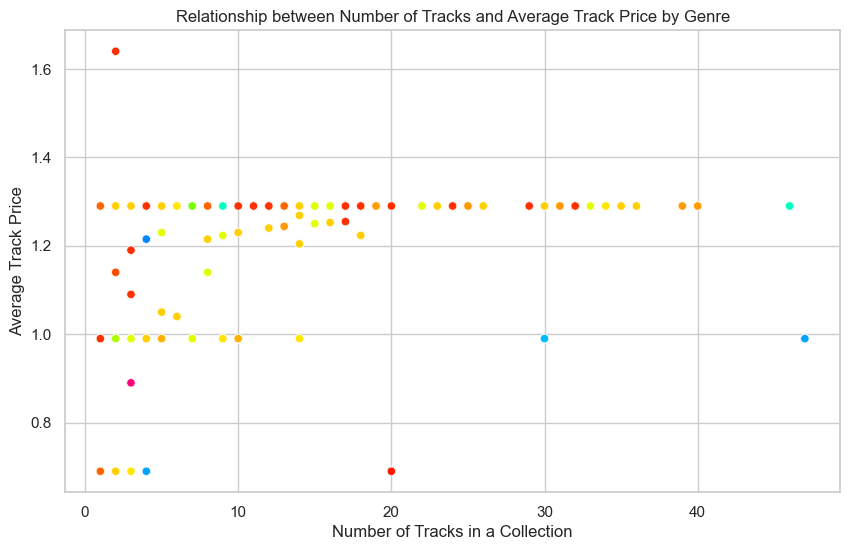

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette for better differentiation between genres
custom_palette = sns.color_palette("hsv", len(q7_data_df['primaryGenreName'].unique()))

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=q7_data_df, x='count', y='avg_price', hue='primaryGenreName', palette=custom_palette, legend=False)
plt.title('Relationship between Number of Tracks and Average Track Price by Genre')
plt.xlabel('Number of Tracks in a Collection')
plt.ylabel('Average Track Price')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


### Q8. Can we identify any outliers in terms of track duration among tracks released by the top 5 artists?

In [103]:
cur = conn.cursor()

cur.execute("""
WITH top_artists AS (
SELECT "artistId", "artistName", RANK() OVER(ORDER BY COUNT("trackId") DESC) AS rank
FROM apple_music_dataset 
GROUP BY "artistId", "artistName"
),

outliers_table AS
(
SELECT "artistId","artistName", COUNT("trackId"),
percentile_cont(0.95) WITHIN GROUP (ORDER BY "trackTimeMillis") AS percentile_95, 
percentile_cont(0.05) WITHIN GROUP (ORDER BY "trackTimeMillis") AS percentile_5 
FROM apple_music_dataset GROUP BY "artistId", "artistName"
)

SELECT t."artistName", ad."trackName", ad."trackTimeMillis", o.percentile_95, o.percentile_5
FROM apple_music_dataset ad RIGHT JOIN outliers_table o
ON o."artistId" = ad."artistId"
JOIN top_artists t ON t."artistId" = o."artistId"
WHERE t.rank <= 5 AND (ad."trackTimeMillis" > o.percentile_95 OR ad."trackTimeMillis" < o.percentile_5);
""")
# Get column names from cursor description
column_names_9 = [desc[0] for desc in cur.description]

# Fetch the data
q9_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q9_data_df = pd.DataFrame(q9_data, columns=column_names_9)

cur.close()


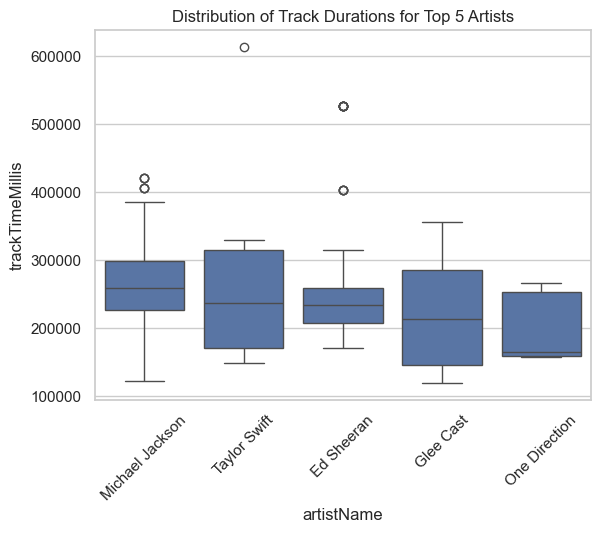

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming q9_data_df is your DataFrame
sns.boxplot(data=q9_data_df, x='artistName', y='trackTimeMillis')
plt.xticks(rotation=45)  # This helps with artist name readability
plt.title('Distribution of Track Durations for Top 5 Artists')
plt.show()


### Q9. How does the release pattern of tracks vary between artists with similar popularity levels but different genres?

In [12]:
cur = conn.cursor()

cur.execute("""

WITH rank_artists AS (
SELECT "artistId", "artistName", "primaryGenreName", RANK() OVER(ORDER BY COUNT("trackId") DESC) AS rank, COUNT("trackId") AS track_count
FROM apple_music_dataset 
GROUP BY "artistId", "artistName", "primaryGenreName"
),
similar_popularity_artists AS (
SELECT "artistId", "artistName", "primaryGenreName", rank, track_count, NTILE(10) OVER(ORDER BY rank) AS popularity_bin --divide artists with same popularity together 
FROM rank_artists
)

SELECT s.popularity_bin, s."primaryGenreName", TO_CHAR("releaseDate", 'Month') AS release_month, COUNT(a."trackId") AS released_track_count
FROM similar_popularity_artists s JOIN apple_music_dataset a 
ON s."artistId" = a."artistId"
GROUP BY s.popularity_bin, s."primaryGenreName", TO_CHAR("releaseDate", 'Month');

""")
# Get column names from cursor description
column_names_10 = [desc[0] for desc in cur.description]

# Fetch the data
q10_data = cur.fetchall()

# Create DataFrame with fetched data and column names
q10_data_df = pd.DataFrame(q10_data, columns=column_names_10)

cur.close()


/var/folders/9f/45cygnj93kn1977lgwr13g140000gn/T/ipykernel_65808/4113021744.py:5: FutureWarning: The provided callable <function sum at 0x103c8d760> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_df = q10_data_df.pivot_table(index='popularity_bin', columns='release_month', values='released_track_count', aggfunc=np.sum)
/var/folders/9f/45cygnj93kn1977lgwr13g140000gn/T/ipykernel_65808/4113021744.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Count of Released Tracks')


AttributeError: 'Index' object has no attribute 'strftime'

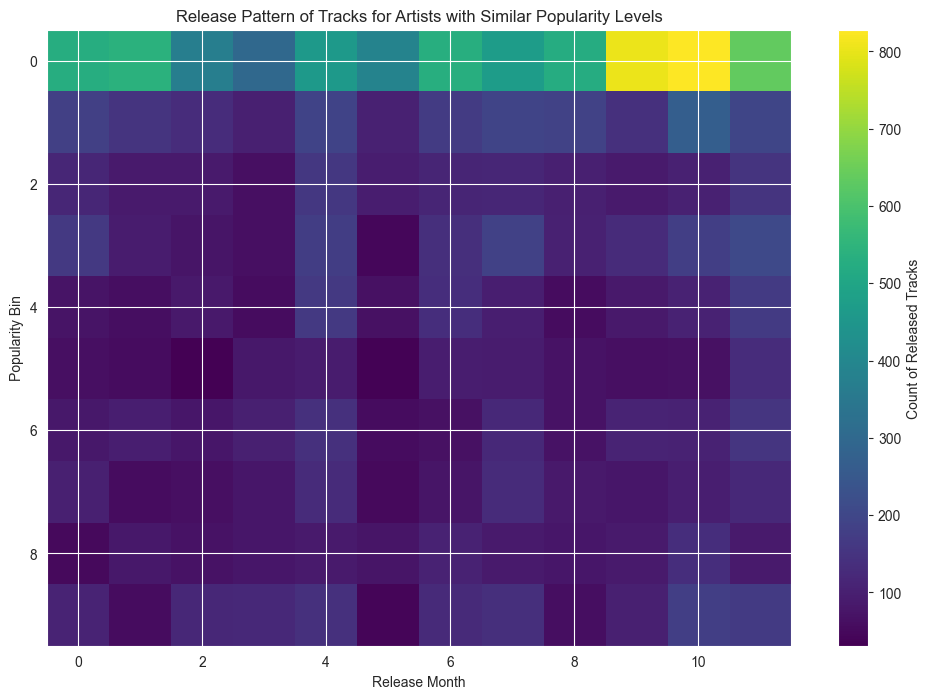

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot the DataFrame
pivot_df = q10_data_df.pivot_table(index='popularity_bin', columns='release_month', values='released_track_count', aggfunc=np.sum)

# Convert pivot table to numpy array
heatmap_data = pivot_df.to_numpy()

# Plot heatmap
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Count of Released Tracks')
plt.title('Release Pattern of Tracks for Artists with Similar Popularity Levels')
plt.xlabel('Release Month')
plt.ylabel('Popularity Bin')
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns.strftime('%Y-%m'), rotation=45)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.tight_layout()
plt.show()


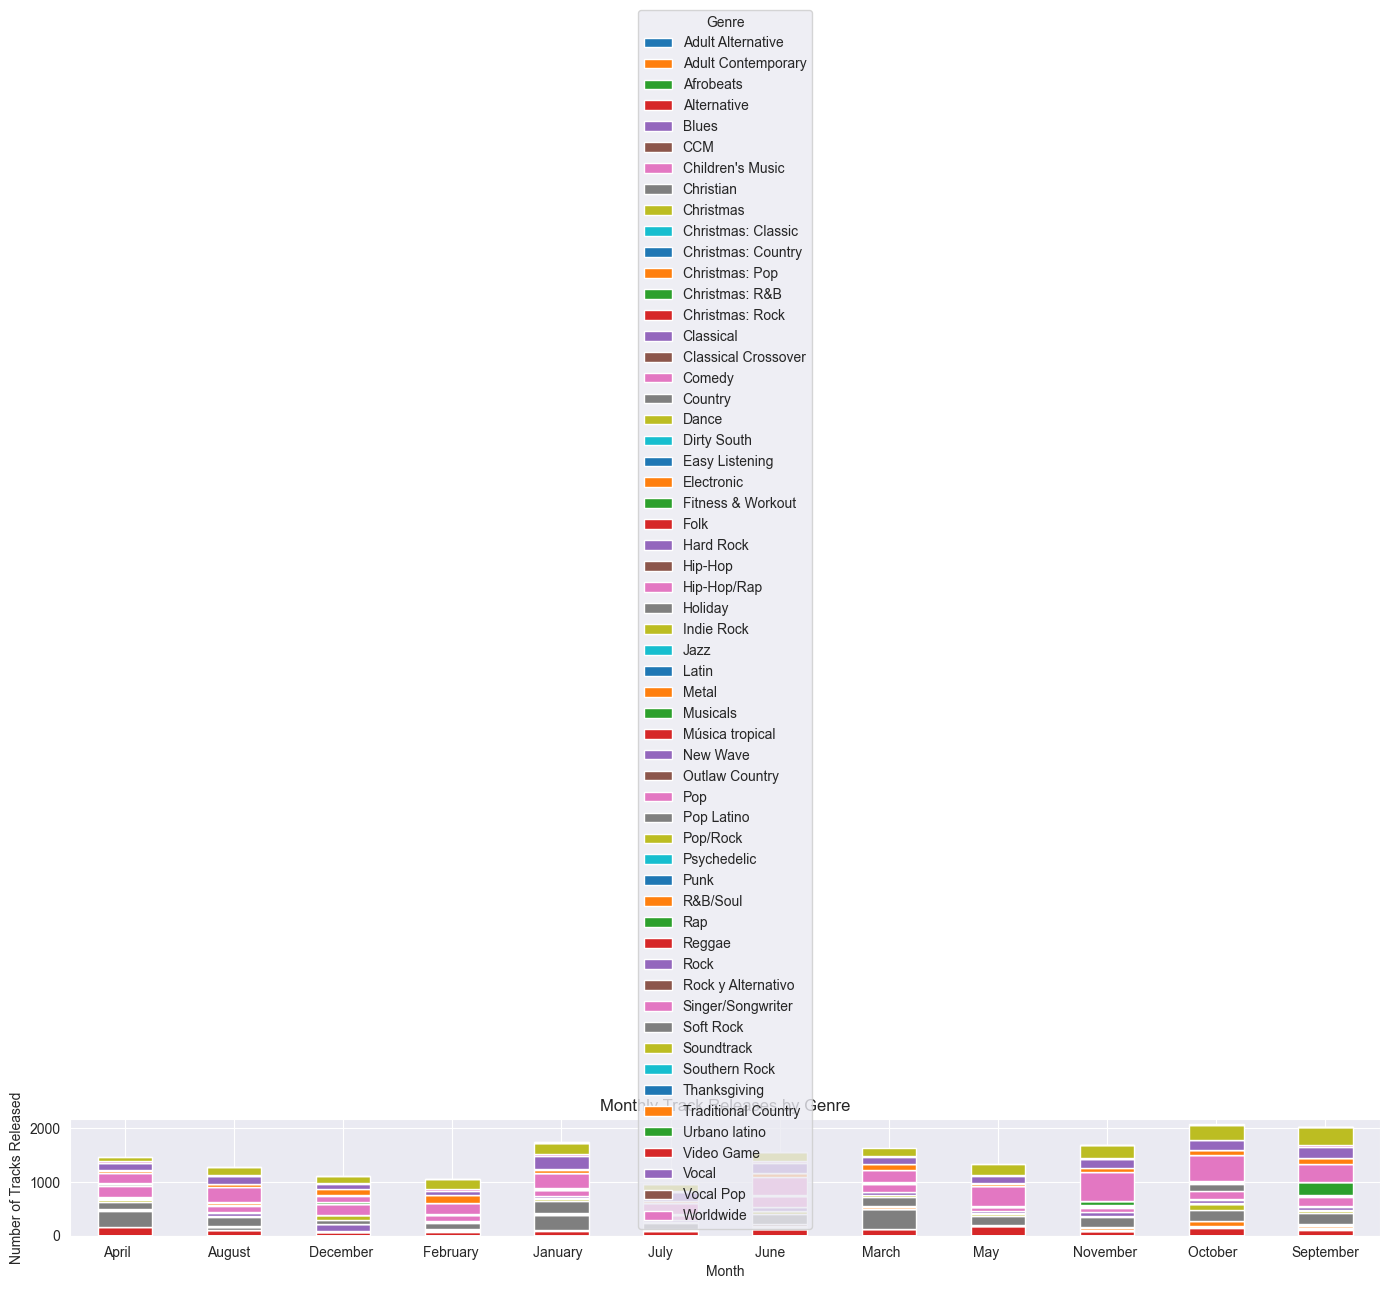

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming q10_data_df is your DataFrame with the columns: popularity_bin, primaryGenreName, release_month, and released_track_count
# Preparing the data
pivot_df = q10_data_df.pivot_table(index='release_month', columns='primaryGenreName', values='released_track_count', aggfunc='sum', fill_value=0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Monthly Track Releases by Genre')
plt.xlabel('Month')
plt.ylabel('Number of Tracks Released')
plt.xticks(rotation=0)
plt.legend(title='Genre')
plt.tight_layout()
plt.show()


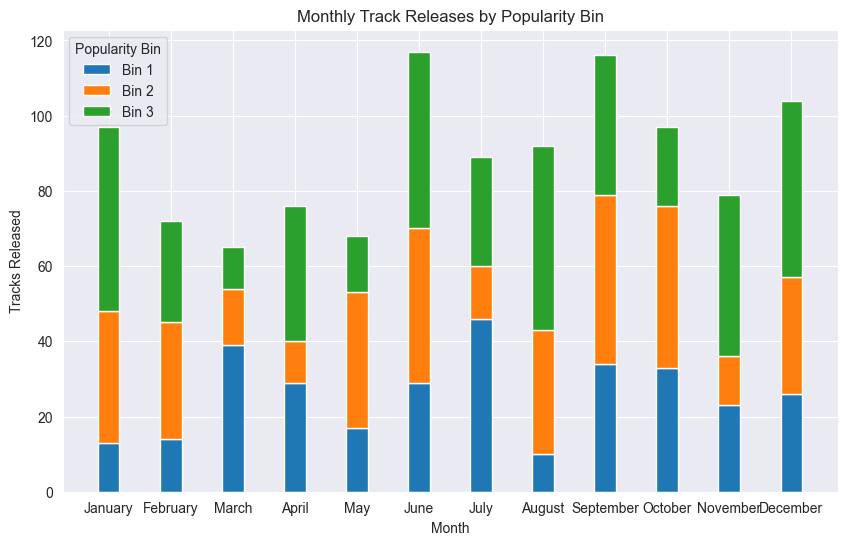

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrays
months = np.array(['January', 'February', 'March','April','May','June','July','August','September','October','November','December'])
popularity_bins = np.array(['Bin 1', 'Bin 2', 'Bin 3'])
# Example data: rows are months, columns are popularity bins
data = np.random.randint(10, 50, size=(len(months), len(popularity_bins)))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Bar width
ind = np.arange(len(months))  # The x locations for the groups

# Stack bars by plotting them on top of each other
bottoms = np.zeros(len(months))
for i in range(len(popularity_bins)):
    ax.bar(ind, data[:, i], width, bottom=bottoms, label=popularity_bins[i])
    bottoms += data[:, i]

ax.set_xlabel('Month')
ax.set_ylabel('Tracks Released')
ax.set_title('Monthly Track Releases by Popularity Bin')
ax.set_xticks(ind)
ax.set_xticklabels(months)
ax.legend(title='Popularity Bin')

plt.show()
